In [1]:
from google.colab import drive
# Подключение Google Диска
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Копирование файла из каталога Google Диска в текущее рабочее пространство
!cp /content/drive/MyDrive/train.csv /content/

!cp /content/drive/MyDrive/test.csv /content/


ДЗ на ARIMA
Набор данных содержит смоделированные временные ряды, охватывающие 10 лет (2010-2019). Файл train.csv охватывает 2010-2018 годы, а файл test.csv - только 2019 год. В данных 7 уникальных магазинов и 10 уникальных товаров. Пропущенных значений нет.

Задача: спрогнозировать продажи в test.csv с помощью моделей ARIMA или SARIMA.

Требуется:

Анализ данных
Обработка данных
Оценка качества модели с помощью анализа остатков модели
Оценка качества предсказаний с помощью метрик mape, rmse, r2
Колонки с id магазина или id товара могут оказаться бесполезными, их разрешается удалить и работать только с колонкой продаж.

Решение присылать в виде ссылки github на открытый репозиторий

In [3]:
!pip install pandas numpy matplotlib statsmodels scikit-learn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score


In [5]:
# Загрузка данных
train = pd.read_csv('train.csv', parse_dates=True, index_col='Date')
test = pd.read_csv('test.csv', parse_dates=True, index_col='Date')

## Анализ данных

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230090 entries, 2010-01-01 to 2018-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   store        230090 non-null  int64
 1   product      230090 non-null  int64
 2   number_sold  230090 non-null  int64
dtypes: int64(3)
memory usage: 7.0 MB


In [7]:
df = train.copy()

            store  product  number_sold
Date                                   
2010-01-01      0        0          801
2010-01-02      0        0          810
2010-01-03      0        0          818
2010-01-04      0        0          796
2010-01-05      0        0          808
               store        product    number_sold
count  230090.000000  230090.000000  230090.000000
mean        3.000000       4.500000     780.926107
std         2.000004       2.872288     204.096737
min         0.000000       0.000000     238.000000
25%         1.000000       2.000000     722.000000
50%         3.000000       4.500000     835.000000
75%         5.000000       7.000000     914.000000
max         6.000000       9.000000    1205.000000


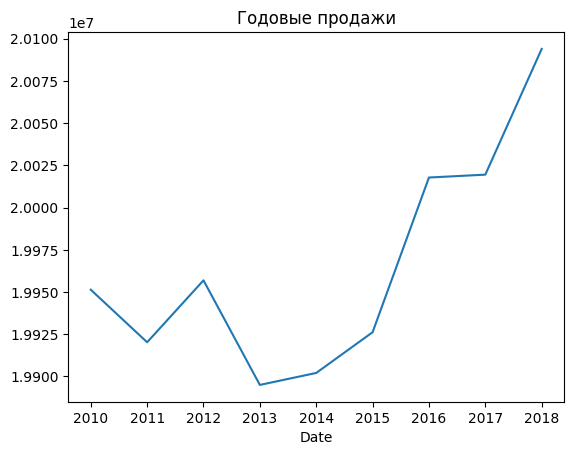

In [8]:
# Быстрый анализ данных
print(df.head())
print(df.describe())

# Проверка временных рядов на наличие трендов и сезонности
df.groupby(df.index.year).sum()['number_sold'].plot()
plt.title("Годовые продажи")
plt.show()


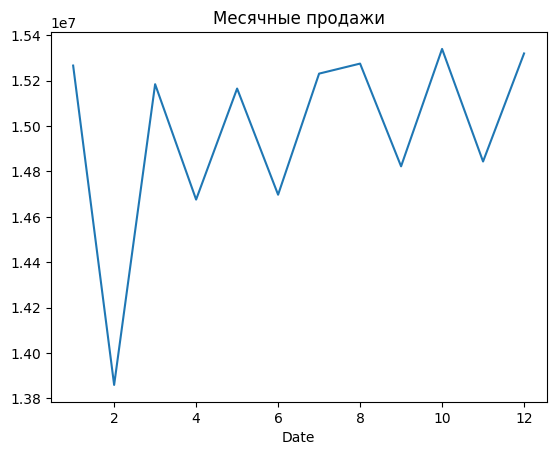

In [9]:
# Проверка временных рядов на наличие трендов и сезонности
df.groupby(df.index.month).sum()['number_sold'].plot()
plt.title("Месячные продажи")
plt.show()

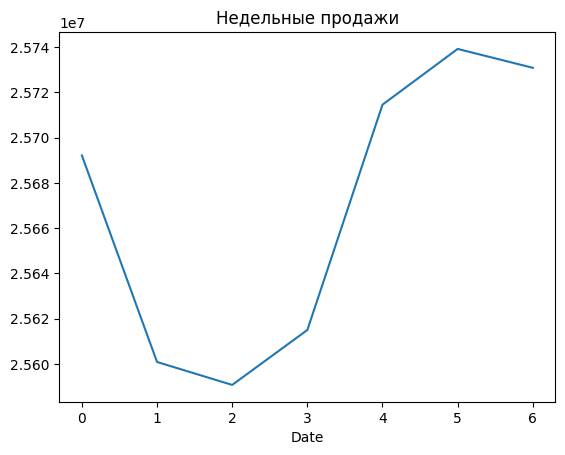

In [10]:
# Проверка временных рядов на наличие трендов и сезонности
df.groupby(df.index.weekday).sum()['number_sold'].plot()
plt.title("Недельные продажи")
plt.show()

In [11]:
df['time'] = np.arange(len(df.index))
print(train.head())

            store  product  number_sold
Date                                   
2010-01-01      0        0          801
2010-01-02      0        0          810
2010-01-03      0        0          818
2010-01-04      0        0          796
2010-01-05      0        0          808


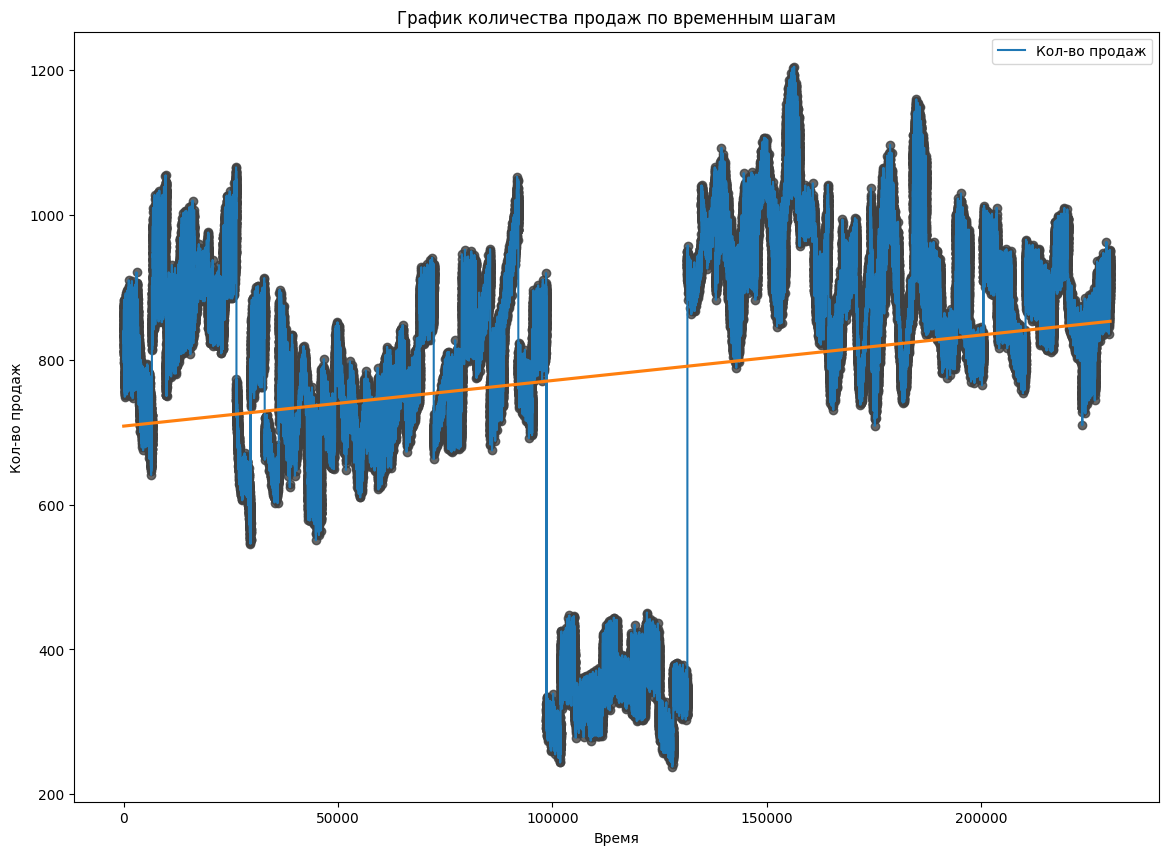

In [12]:
import seaborn as sns

# Задаём размер визуализации
fig, ax = plt.subplots(figsize=(14, 10))

# Построение линейчатого графика временного ряда
ax.plot(df['time'], df['number_sold'], label='Кол-во продаж')

# Добавление линии регрессии с помощью Seaborn
sns.regplot(x='time', y='number_sold', data=df, ci=None, scatter_kws=dict(color='0.25'), ax=ax)

ax.set_title('График количества продаж по временным шагам')
ax.set_xlabel('Время')
ax.set_ylabel('Кол-во продаж')
ax.legend()
plt.show()

In [13]:
df['lag_1'] = df['number_sold'].shift(1)
df.head()

,store,product,number_sold,time,lag_1
Date,,,,,
2010-01-01,0,0,801,0,NaN
2010-01-02,0,0,810,1,801.0
2010-01-03,0,0,818,2,810.0
2010-01-04,0,0,796,3,818.0
2010-01-05,0,0,808,4,796.0


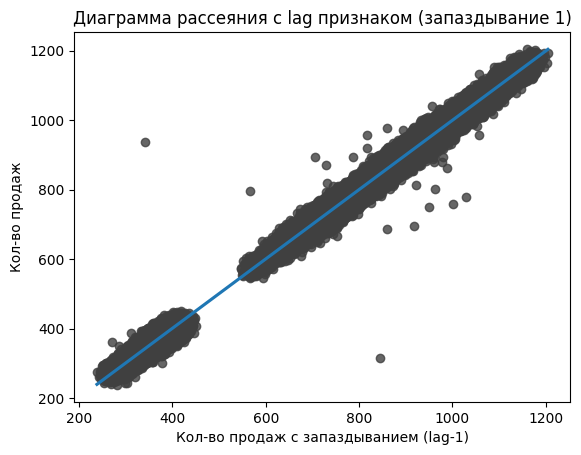

In [14]:
df.dropna(inplace=True)

fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='number_sold', data=df, ci=None, scatter_kws=dict(color='0.25'))

# Устанавливаем заголовок и подписи осей
ax.set_title('Диаграмма рассеяния с lag признаком (запаздывание 1)')
ax.set_xlabel('Кол-во продаж с запаздыванием (lag-1)')
ax.set_ylabel('Кол-во продаж')

plt.show()

На точечной диаграмме "Диаграмма рассеивания с запаздыванием lag 1" видно, что цены на продукты в текущий день значительно коррелируют с ценами предыдущего дня. В таких случаях использование лагов может быть чрезвычайно полезным, поскольку они позволяют моделировать серийную зависимость. Временной ряд обладает серийной зависимостью, когда текущее наблюдение можно предсказать на основе предыдущих значений.

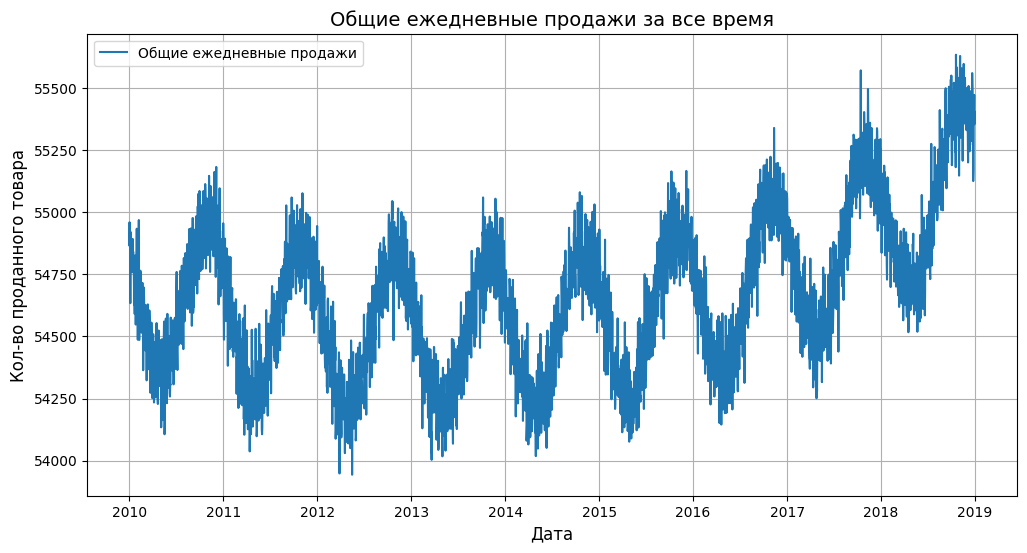

In [15]:
daily_sold = train.groupby('Date')['number_sold'].sum()
plt.figure(figsize=(12, 6))
plt.plot(daily_sold, label='Общие ежедневные продажи')
plt.title('Общие ежедневные продажи за все время', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кол-во проданного товара', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Из графика "Общие ежедневные продажи за все время" видно, что присутствуют сезонные колебания. Для прогноза будем использовать модель SARIMA, так как она расширяет возможности стандартной модели ARIMA, поддерживая учет сезонных компонентов.

In [16]:
train_data = train.drop(columns=['store', 'product'])
test_data = test.drop(columns=['store', 'product'])

train_sum = train_data.groupby('Date')['number_sold'].sum().reset_index()
test_sum = test_data.groupby('Date')['number_sold'].sum().reset_index()

print("Обобщенные данные для обучения:")
print(train_sum.head())

print("\nОбобщенные данные для тестирования:")
print(test_sum.head())

Обобщенные данные для обучения:
        Date  number_sold
0 2010-01-01        54870
1 2010-01-02        54960
2 2010-01-03        54863
3 2010-01-04        54926
4 2010-01-05        54634

Обобщенные данные для тестирования:
        Date  number_sold
0 2019-01-01        55221
1 2019-01-02        55287
2 2019-01-03        55302
3 2019-01-04        55407
4 2019-01-05        55289


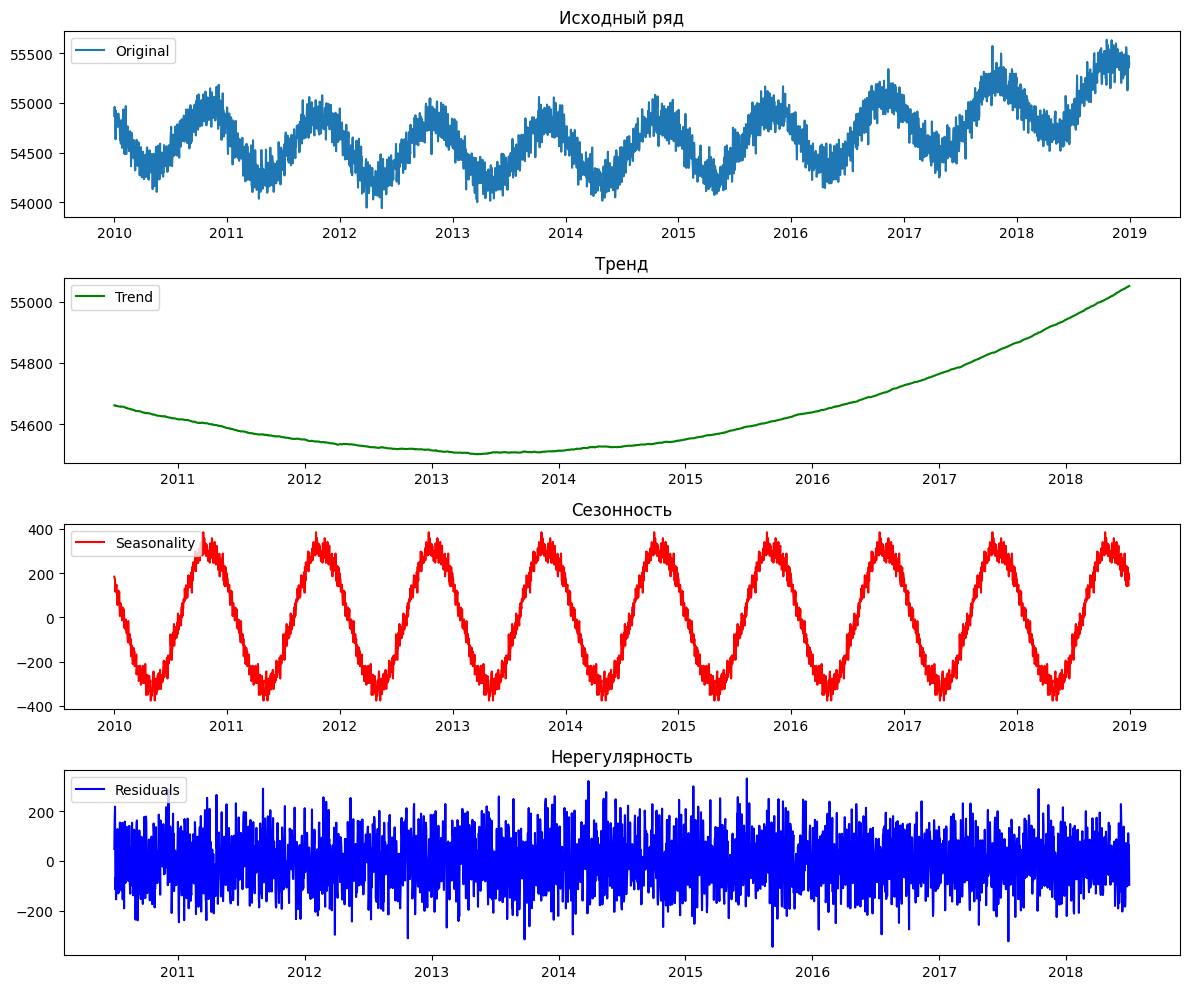

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train_sum['number_sold'], model='addaptive', period=365)


plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(train_sum['Date'], train_sum['number_sold'], label='Original')
plt.title('Исходный ряд')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(train_sum['Date'], result.trend, label='Trend', color='green')
plt.title('Тренд')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(train_sum['Date'], result.seasonal, label='Seasonality', color='red')
plt.title('Сезонность')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(train_sum['Date'], result.resid, label='Residuals', color='blue')
plt.title('Нерегулярность')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


Исходный ряд: видны годовая сезонность и восходящий тренд.

Тренд: тренд восходящий.

Сезонность: годовая сезонность.

Нерегулярность: остатки имеют случайный характер.

In [19]:
from statsmodels.tsa.stattools import adfuller


# тест Дикки-Фуллера с поправкой на автокорреляцию (ADF-тест)
result_adf = adfuller(train_sum['number_sold'])
print('ADF Test:')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
print(f'Critical Values:')
for key, value in result_adf[4].items():
    print(f'   {key}: {value}')

ADF Test:
ADF Statistic: -2.532369713456244
p-value: 0.10779573173603202
Critical Values:
   1%: -3.4323593525669414
   5%: -2.8624278120183573
   10%: -2.567242601304915


Поскольку ADF-тестовая статистика (-2.532) больше критических значений на уровне 1%, 5%, и 10%, и p-value не достаточно низкое (менее 0.05), мы не можем отвергнуть нулевую гипотезу о наличии единичного корня. Это указывает на то, что временной ряд вероятно является нестационарным.

In [20]:
from statsmodels.tsa.stattools import kpss

# тест Квитка-Филлипса-Шмидта-Шина (KPSS-тест)
result_kpss = kpss((train_sum['number_sold']), regression='c')
print('KPSS Test:')
print(f'KPSS Statistic: {result_kpss[0]}')
print(f'p-value: {result_kpss[1]}')
print(f'Critical Values:')
for key, value in result_kpss[3].items():
    print(f'   {key}: {value}')

KPSS Test:
KPSS Statistic: 2.3773912770798606
p-value: 0.01
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


<ipython-input-20-222fe7c86f16>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss((train_sum['number_sold']), regression='c')


Поскольку значение статистики KPSS значительно превышает даже самое строгое критическое значение (1%: 0.739), нулевая гипотеза о стационарности временного ряда отвергается. Это указывает на то, что временной ряд, вероятно, нестационарен.

На основании проведенных тестов можно сделать вывод: данный временной ряд не является стационарным, и, вероятно, требуется применение преобразований, таких как дифференцирование или другие методы, для его стационирования, прежде чем использовать его в моделировании временных рядов, таких как ARIMA/SARIMA.

In [21]:
train_sum['diff'] = train_sum['number_sold'].diff()
result_diff = adfuller(train_sum['diff'].dropna())

In [22]:
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:", result_diff[4])

if result_diff[1] < 0.05:
    print("Ряд стационарен после 1-го дифференцирования.")
else:
    print("Ряд все еще не стационарен.")

ADF Statistic: -7.113038701556111
p-value: 3.8942498293818916e-10
Critical Values: {'1%': -3.432359970177518, '5%': -2.862428084811229, '10%': -2.5672427465340872}
Ряд стационарен после 1-го дифференцирования.


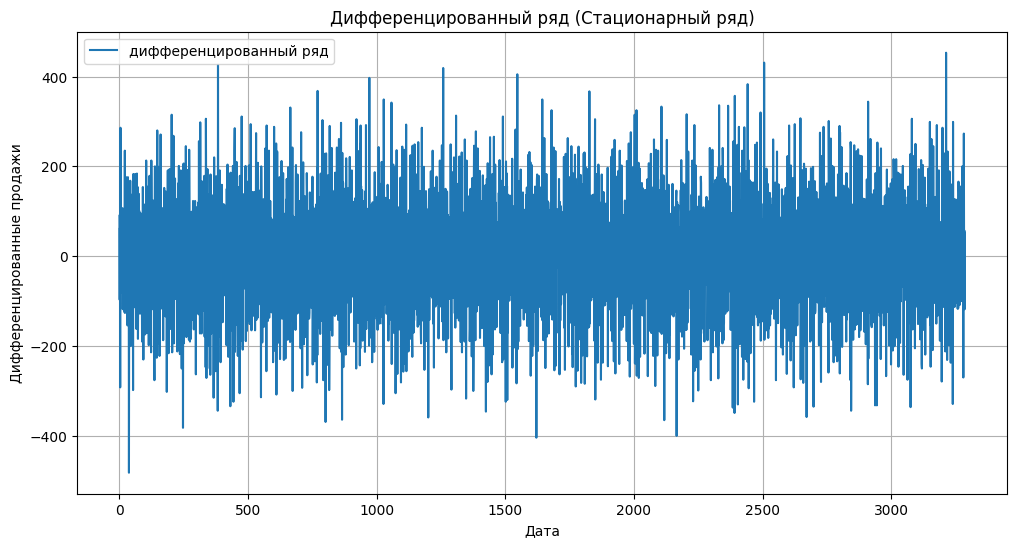

In [23]:

plt.figure(figsize=(12, 6))
plt.plot(train_sum['diff'], label='дифференцированный ряд')
plt.title('Дифференцированный ряд (Стационарный ряд)')
plt.xlabel('Дата')
plt.ylabel('Дифференцированные продажи')
plt.legend()
plt.grid()
plt.show()

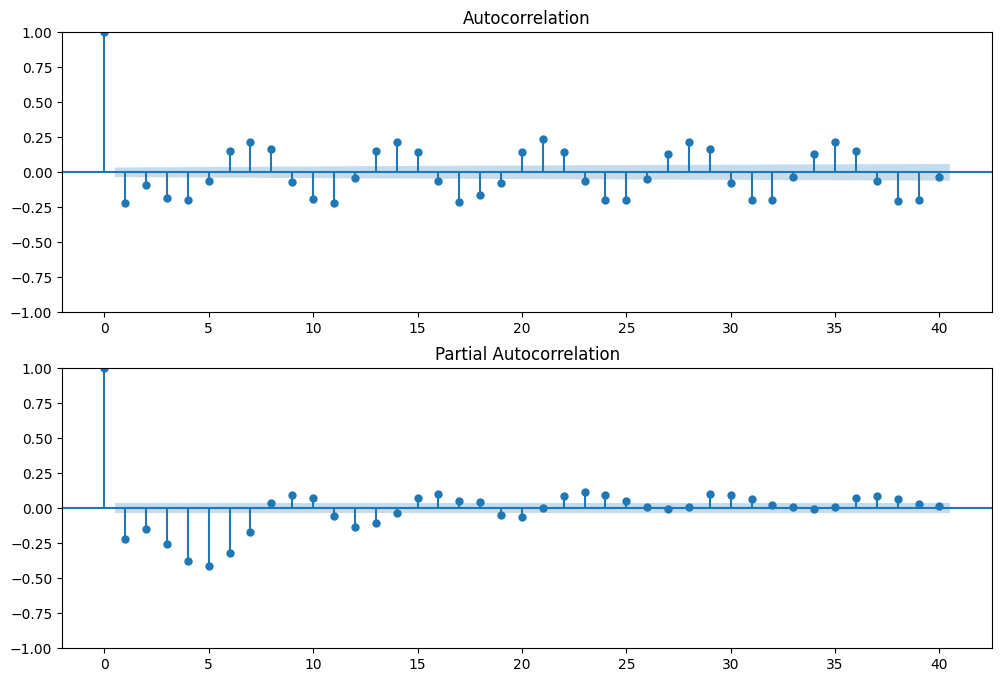

In [24]:
import statsmodels.api as sm

# Анализ ACF и PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(train_sum['diff'].dropna(), ax=ax1, lags=40)
sm.graphics.tsa.plot_pacf(train_sum['diff'].dropna(), ax=ax2, lags=40)
plt.show()

ACF: автокорреляционная функция (ACF) показывает значимые пики на первых нескольких лагах, после чего автокорреляция быстро снижается. Это указывает на то, что значения ряда зависят от недавних значений (лагов 1, 2, 3), но затем эта зависимость ослабевает.

PACF: значимые пики на первых двух лагах (лаг 1, 2) указывают на сильную зависимость значений ряда от 1-2 предыдущих значений.

Исходя из графиков, получаем:  
p = 2  
q = 2

## Модель SARIMA

In [31]:
# перейдем на месячные данные
monthly_train = train_sum.resample('M', on='Date').sum().reset_index()
monthly_test = test_sum.resample('M', on='Date').sum().reset_index()

print(monthly_train.head())
print(monthly_test.head())


        Date  number_sold   diff
0 2010-01-31      1698403  -25.0
1 2010-02-28      1529750 -260.0
2 2010-03-31      1688388 -333.0
3 2010-04-30      1630998  166.0
4 2010-05-31      1685240 -110.0
        Date  number_sold
0 2019-01-31      1713370
1 2019-02-28      1543318
2 2019-03-31      1704861
3 2019-04-30      1647955
4 2019-05-31      1704229


<ipython-input-31-a9251ee4f76f>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_train = train_sum.resample('M', on='Date').sum().reset_index()
<ipython-input-31-a9251ee4f76f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_test = test_sum.resample('M', on='Date').sum().reset_index()


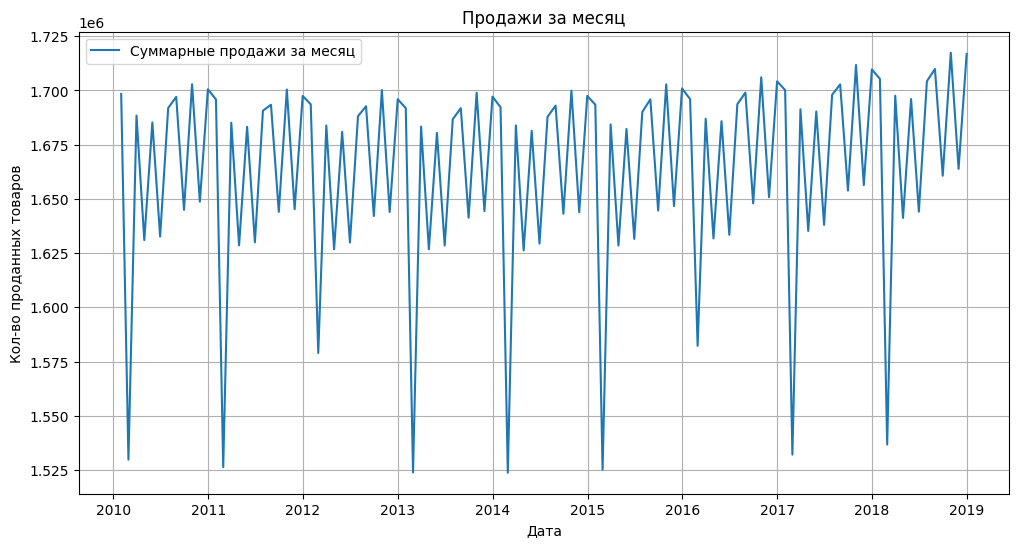

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_train['Date'], monthly_train['number_sold'], label='Суммарные продажи за месяц')
plt.title('Продажи за месяц')
plt.xlabel('Дата')
plt.ylabel('Кол-во проданных товаров')
plt.legend()
plt.grid()
plt.show()

На графике присутствуют выбросы, удалим их.

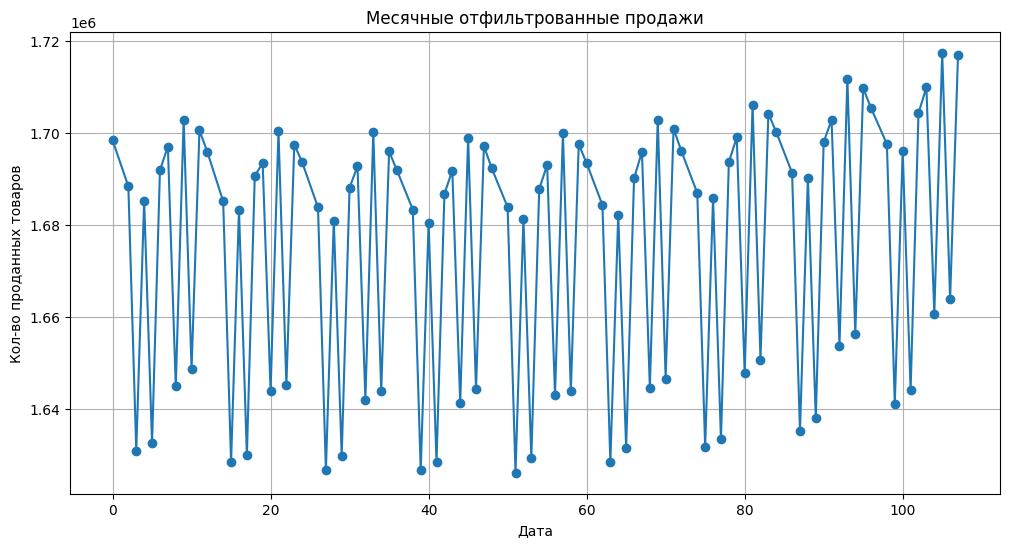

In [27]:
# Фильтрация выбросов
threshold = 1.625 * 1e6
filtered_data = monthly_train[monthly_train['number_sold'] >= threshold]

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['number_sold'], marker='o', linestyle='-')
plt.title('Месячные отфильтрованные продажи')
plt.xlabel('Дата')
plt.ylabel('Кол-во проданных товаров')
plt.grid(True)
plt.show()

In [30]:
# прологарифмируем ряд, чтобы сгладить данные
filtered_data.loc[:, 'log_number_sold'] = np.log(filtered_data['number_sold'])

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    filtered_data.loc[:, 'log_number_sold'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_model = model.fit(disp=False)
print(sarima_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                      log_number_sold   No. Observations:                   99
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                 182.225
Date:                              Sat, 23 Nov 2024   AIC                           -350.451
Time:                                      18:52:07   BIC                           -334.612
Sample:                                           0   HQIC                          -344.152
                                               - 99                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3655      0.431     -3.170      0.002      -2.210      -0.521
ar.L2         -0.60

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


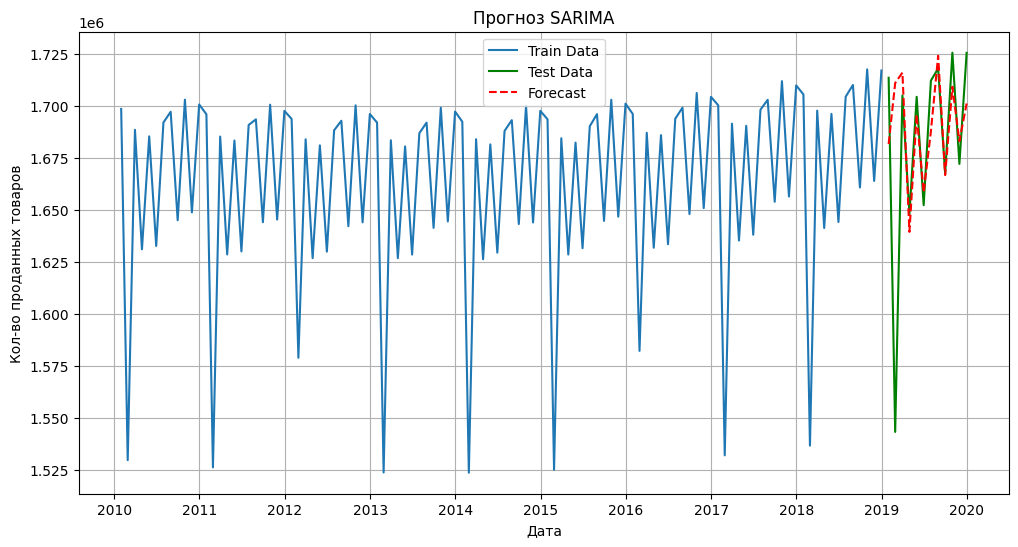

MAPE: 0.0163
RMSE: 50817.8233
R^2: -0.0490


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
forecast_steps = len(monthly_test)
forecast_log = sarima_model.forecast(steps=forecast_steps)

forecast = np.exp(forecast_log)


plt.figure(figsize=(12, 6))
plt.plot(monthly_train['Date'], monthly_train['number_sold'], label='Train Data')
plt.plot(monthly_test['Date'], monthly_test['number_sold'], label='Test Data', color='green' )
plt.plot(monthly_test['Date'], forecast, label='Forecast', linestyle='--', color='red')
plt.title('Прогноз SARIMA')
plt.xlabel('Дата')
plt.ylabel('Кол-во проданных товаров')
plt.legend()
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

mape = mean_absolute_percentage_error(monthly_test['number_sold'], forecast)
rmse = mean_squared_error(monthly_test['number_sold'], forecast, squared=False)
r2 = r2_score(monthly_test['number_sold'], forecast)

print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

Для данного временного ряда полученные метрики могут свидетельствовать о следующих замечаниях и выводах:
1. MAPE (Mean Absolute Percentage Error): значение 0.0163 указывает на очень хорошую относительную точность модели, так как средняя ошибка составляет всего 1.63%. Это может быть признаком того, что модель достаточно хорошо улавливает тренды и сезонные паттерны на уровне относительных изменений.
2. RMSE (Root Mean Square Error): высокое значение 50817.8233 может указывать на значительные абсолютные ошибки, что часто наблюдается в рядах с большим количеством продаж из-за масштаба данных. Это может быть менее критичным, если числовые значения самих продаж также велики.
3. R^2 (Коэффициент детерминации): негативное значение R^2 (-0.0490) указывает, что модель плохо объясняет вариативность данных, хуже, чем просто среднее значение. Это свидетельствует о недостатках модели, которые могут быть связаны с неадекватным учетом тренда и сезонности.

Рекомендации по улучшению модели:
1. Пересмотреть параметры модели SARIMA: возможно, текущие параметры модели не идеально настроены, чтобы учитывать восходящий тренд и годовую сезонность. Возможен тюнинг гиперпараметров модели или моделирование тренда и сезонности более точно.
2. Рассмотреть альтернативы: возможно, стоит попробовать другие модели, такие как Prophet или модели глубокого обучения, чтобы лучше уловить сложные паттерны трендов и сезонности.
3. Разделить и доработать: может быть полезно разделение модели на трендовую и сезонную компоненты для более точной подгонки и последующего восстановления общих прогнозов.
Эти шаги могут помочь улучшить предсказательную способность модели, особенно в условиях больших и сложных временных рядов.